https://en.wikipedia.org/wiki/Rank-maximal_allocation

# Installs

In [1]:
!pip install scipy numpy pandas seaborn xlrd openpyxl
%config Completer.use_jedi = False

You should consider upgrading via the '/Users/admin/.pyenv/versions/3.9.16/bin/python3.9 -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
import scipy.optimize

import json

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

import seaborn as sns
sns.set()

# Hungarian Algorithm

In [3]:
# Hungarian algorithm (Kuhn-Munkres) for solving the linear sum assignment
# problem. Taken from scikit-learn. Based on original code by Brian Clapper,
# adapted to NumPy by Gael Varoquaux.
# Further improvements by Ben Root, Vlad Niculae and Lars Buitinck.
#
# Copyright (c) 2008 Brian M. Clapper <bmc@clapper.org>, Gael Varoquaux
# Author: Brian M. Clapper, Gael Varoquaux
# License: 3-clause BSD

def linear_sum_assignment(cost_matrix):
    """Solve the linear sum assignment problem.

    The linear sum assignment problem is also known as minimum weight matching
    in bipartite graphs. A problem instance is described by a matrix C, where
    each C[i,j] is the cost of matching vertex i of the first partite set
    (a "worker") and vertex j of the second set (a "job"). The goal is to find
    a complete assignment of workers to jobs of minimal cost.

    Formally, let X be a boolean matrix where :math:`X[i,j] = 1` iff row i is
    assigned to column j. Then the optimal assignment has cost

    .. math::
        \min \sum_i \sum_j C_{i,j} X_{i,j}

    s.t. each row is assignment to at most one column, and each column to at
    most one row.

    This function can also solve a generalization of the classic assignment
    problem where the cost matrix is rectangular. If it has more rows than
    columns, then not every row needs to be assigned to a column, and vice
    versa.

    The method used is the Hungarian algorithm, also known as the Munkres or
    Kuhn-Munkres algorithm.

    Parameters
    ----------
    cost_matrix : array
        The cost matrix of the bipartite graph.

    Returns
    -------
    row_ind, col_ind : array
        An array of row indices and one of corresponding column indices giving
        the optimal assignment. The cost of the assignment can be computed
        as ``cost_matrix[row_ind, col_ind].sum()``. The row indices will be
        sorted; in the case of a square cost matrix they will be equal to
        ``numpy.arange(cost_matrix.shape[0])``.

    Notes
    -----
    .. versionadded:: 0.17.0

    Examples
    --------
    >>> cost = np.array([[4, 1, 3], [2, 0, 5], [3, 2, 2]])
    >>> from scipy.optimize import linear_sum_assignment
    >>> row_ind, col_ind = linear_sum_assignment(cost)
    >>> col_ind
    array([1, 0, 2])
    >>> cost[row_ind, col_ind].sum()
    5

    References
    ----------
    1. http://csclab.murraystate.edu/bob.pilgrim/445/munkres.html

    2. Harold W. Kuhn. The Hungarian Method for the assignment problem.
       *Naval Research Logistics Quarterly*, 2:83-97, 1955.

    3. Harold W. Kuhn. Variants of the Hungarian method for assignment
       problems. *Naval Research Logistics Quarterly*, 3: 253-258, 1956.

    4. Munkres, J. Algorithms for the Assignment and Transportation Problems.
       *J. SIAM*, 5(1):32-38, March, 1957.

    5. https://en.wikipedia.org/wiki/Hungarian_algorithm
    """
    cost_matrix = np.asarray(cost_matrix)
    if len(cost_matrix.shape) != 2:
        raise ValueError("expected a matrix (2-d array), got a %r array"
                         % (cost_matrix.shape,))

    # The algorithm expects more columns than rows in the cost matrix.
    if cost_matrix.shape[1] < cost_matrix.shape[0]:
        cost_matrix = cost_matrix.T
        transposed = True
    else:
        transposed = False

    state = _Hungary(cost_matrix)

    # No need to bother with assignments if one of the dimensions
    # of the cost matrix is zero-length.
    step = None if 0 in cost_matrix.shape else _step1

    while step is not None:
        step = step(state)

    if transposed:
        marked = state.marked.T
    else:
        marked = state.marked
    return np.where(marked == 1)


class _Hungary(object):
    """State of the Hungarian algorithm.

    Parameters
    ----------
    cost_matrix : 2D matrix
        The cost matrix. Must have shape[1] >= shape[0].
    """

    def __init__(self, cost_matrix):
        self.C = cost_matrix.copy()

        n, m = self.C.shape
        self.row_uncovered = np.ones(n, dtype=bool)
        self.col_uncovered = np.ones(m, dtype=bool)
        self.Z0_r = 0
        self.Z0_c = 0
        self.path = np.zeros((n + m, 2), dtype=int)
        self.marked = np.zeros((n, m), dtype=int)

    def _clear_covers(self):
        """Clear all covered matrix cells"""
        self.row_uncovered[:] = True
        self.col_uncovered[:] = True


# Individual steps of the algorithm follow, as a state machine: they return
# the next step to be taken (function to be called), if any.

def _step1(state):
    """Steps 1 and 2 in the Wikipedia page."""

    # Step 1: For each row of the matrix, find the smallest element and
    # subtract it from every element in its row.
    state.C -= state.C.min(axis=1)[:, np.newaxis]
    # Step 2: Find a zero (Z) in the resulting matrix. If there is no
    # starred zero in its row or column, star Z. Repeat for each element
    # in the matrix.
    for i, j in zip(*np.where(state.C == 0)):
        if state.col_uncovered[j] and state.row_uncovered[i]:
            state.marked[i, j] = 1
            state.col_uncovered[j] = False
            state.row_uncovered[i] = False

    state._clear_covers()
    return _step3


def _step3(state):
    """
    Cover each column containing a starred zero. If n columns are covered,
    the starred zeros describe a complete set of unique assignments.
    In this case, Go to DONE, otherwise, Go to Step 4.
    """
    marked = (state.marked == 1)
    state.col_uncovered[np.any(marked, axis=0)] = False

    if marked.sum() < state.C.shape[0]:
        return _step4


def _step4(state):
    """
    Find a noncovered zero and prime it. If there is no starred zero
    in the row containing this primed zero, Go to Step 5. Otherwise,
    cover this row and uncover the column containing the starred
    zero. Continue in this manner until there are no uncovered zeros
    left. Save the smallest uncovered value and Go to Step 6.
    """
    # We convert to int as numpy operations are faster on int
    C = (state.C == 0).astype(int)
    covered_C = C * state.row_uncovered[:, np.newaxis]
    covered_C *= np.asarray(state.col_uncovered, dtype=int)
    n = state.C.shape[0]
    m = state.C.shape[1]

    while True:
        # Find an uncovered zero
        row, col = np.unravel_index(np.argmax(covered_C), (n, m))
        if covered_C[row, col] == 0:
            return _step6
        else:
            state.marked[row, col] = 2
            # Find the first starred element in the row
            star_col = np.argmax(state.marked[row] == 1)
            if state.marked[row, star_col] != 1:
                # Could not find one
                state.Z0_r = row
                state.Z0_c = col
                return _step5
            else:
                col = star_col
                state.row_uncovered[row] = False
                state.col_uncovered[col] = True
                covered_C[:, col] = C[:, col] * (
                    np.asarray(state.row_uncovered, dtype=int))
                covered_C[row] = 0


def _step5(state):
    """
    Construct a series of alternating primed and starred zeros as follows.
    Let Z0 represent the uncovered primed zero found in Step 4.
    Let Z1 denote the starred zero in the column of Z0 (if any).
    Let Z2 denote the primed zero in the row of Z1 (there will always be one).
    Continue until the series terminates at a primed zero that has no starred
    zero in its column. Unstar each starred zero of the series, star each
    primed zero of the series, erase all primes and uncover every line in the
    matrix. Return to Step 3
    """
    count = 0
    path = state.path
    path[count, 0] = state.Z0_r
    path[count, 1] = state.Z0_c

    while True:
        # Find the first starred element in the col defined by
        # the path.
        row = np.argmax(state.marked[:, path[count, 1]] == 1)
        if state.marked[row, path[count, 1]] != 1:
            # Could not find one
            break
        else:
            count += 1
            path[count, 0] = row
            path[count, 1] = path[count - 1, 1]

        # Find the first prime element in the row defined by the
        # first path step
        col = np.argmax(state.marked[path[count, 0]] == 2)
        if state.marked[row, col] != 2:
            col = -1
        count += 1
        path[count, 0] = path[count - 1, 0]
        path[count, 1] = col

    # Convert paths
    for i in range(count + 1):
        if state.marked[path[i, 0], path[i, 1]] == 1:
            state.marked[path[i, 0], path[i, 1]] = 0
        else:
            state.marked[path[i, 0], path[i, 1]] = 1

    state._clear_covers()
    # Erase all prime markings
    state.marked[state.marked == 2] = 0
    return _step3


def _step6(state):
    """
    Add the value found in Step 4 to every element of each covered row,
    and subtract it from every element of each uncovered column.
    Return to Step 4 without altering any stars, primes, or covered lines.
    """
    # the smallest uncovered value in the matrix
    if np.any(state.row_uncovered) and np.any(state.col_uncovered):
        minval = np.min(state.C[state.row_uncovered], axis=0)
        minval = np.min(minval[state.col_uncovered])
        state.C[~state.row_uncovered] += minval
        state.C[:, state.col_uncovered] -= minval
    return _step4

# Classes

We have $n$ applicants to $m$ jobs

In [4]:
class Profile:
    @staticmethod
    def compute_profile(ranks, applicants, jobs):
        """
        Returns the profile of a matching of applicants to jobs given the overall ranks.

            Parameters:
                ranks (np.ndarray): an n x m matrix of rankings, where ranks[i,j] is the rank of applicant i for job j
                applicants (np.ndarray): an n-vector of applicant indices
                jobs (np.ndarray): an m-vector of selected jobs corresponding to each applicant, so that jobs[i] is the choice of job for applicant[i]

            Returns:
                profile (np.ndarray): an m-vector where profile[i] is the number of applicants who were assigned their i'th pick of job
        """
        
        # applicants may be in an order different than [0, 1, 2, ...]
        selected_ranks = ranks[applicants]
        (n, m)  = selected_ranks.shape

        # Argsort turns an array of ranks into a list of jobs, ranked
        argsort = np.argsort(selected_ranks, axis=1)

        profile = np.zeros(m)

        for j in range(m):
            # Count how many jobs ranked 1st by applicants are equal to the jobs assigned.
            # Then, count how many jobs ranked 2nd were equal to the jobs assigned. etc.
            profile[j] = (argsort[:, j] == jobs).sum()

        # we should have assigned one job for each applicant.
        assert profile.sum() == n
        return profile
    
    @staticmethod
    def compare_profiles(a, b):
        """
        Used to compare profiles in lexicographic order.

            Parameters:
                a (np.ndarray): a profile for a matching. An m-vector where profile[i] is the number of applicants who were assigned their i'th pick of job
                b (np.ndarray): a profile for a matching.

            Returns:
                1  if b < a
                -1 if a < b
                0  if a = b
        """
        where = np.where( (a>b) != (a<b) )
        if where[0].size == 0:
            # they are identical
            return 0

        idx = where[0][0]

        if a[idx] < b[idx]:
            return -1
        elif a[idx] > b[idx]:
            return 1
        
    @staticmethod
    def compute_profile_from_result(ranks, matching):
        """
        Computes the profile from the output of the human-friendly algorithm.
        
            Parameters:
            Parameters:
                ranks (dict): a dictionary {[applicant]: {[job]: [ranking]}}
                matching (dict): a dictionary of {[applicant]: [job1, job2, ...]} of selected jobs.
                
            Returns:
                profile (np.ndarray): an m-vector where profile[i] is the number of applicants who were assigned their i'th pick of job
                
        """
        m = len(ranks[list(ranks.keys())[0]])
        profile = np.zeros(m, dtype=int)
        for applicant in ranks:
            for job in ranks[applicant]:
                rank = ranks[applicant][job]
                if job in matching[applicant]:
                    profile[rank] += 1
        assert profile.sum() == m
        return profile


In [5]:
class RankMaximalAllocation:
    @classmethod
    def generate_matching(cls, ranks):
        """
        Returns a tuple (applicants, jobs) corresponding to a bipartite graph matching between applicants and jobs.
        
            Parameters:
                ranks (np.ndarray): an n x m matrix of rankings, where ranks[i,j] is the rank of applicant i for job j
        
            Returns:
                applicants: a vector of length min(n, m) of the selected applicants. A vector of indices.
                jobs: a vector of length min(n, m) of the selected jobs. A vector of indices.
                
                The computed matching is essentially [(applicants[0], jobs[0]), applicants[1], jobs[1], ...]
                The retured format is more efficient for indexing operations.
        
        """
        weights = cls.compute_weights(ranks)
        applicants, jobs = linear_sum_assignment(weights)
        return applicants, jobs
    
    @staticmethod
    def compute_weights(ranks):
        """
        Returns a weight matrix the same shape as ranks. Used with linear sum assignment.
        
            Parameters:
                ranks (np.ndarray): an n x m matrix of rankings, where ranks[i,j] is the rank of applicant i for job j

            Returns:
                weights (np.ndarray): an n x m matrix of weights. Selecting at most one element from each row/column of this matrix should result in a minimum sum.
        
        Cited from Greedy Matchings by Robert W. Irving
        https://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=0D4318167ED18A3CE8DF2FB5B2EA8321?doi=10.1.1.119.1747&rep=rep1&type=pdf
        
        > However, a greedy matching can be found by transforming to an instance of the classical
        > maximum weight bipartite matching problem. This involves allo cating a suitably steeply 
        > decreasing sequence of weights to the positions in each applicant's preference list to 
        > ensure that, for any value of i, an applicant who improves from his (i+1)th to his ith 
        > choice would change the weight of applicants who move down from their (i+j)th choice, 
        > for any value of j >= 1. This can be achieved, for example, by assigning a weight of 
        > n^(m-i) to each applicant's ith choice.
        """
        (n, m) = ranks.shape
        
        # we use object to take advantage of numpy's broadcasting
        # and python's unlimited integer representation
        weights = np.array(n, dtype=object)**(np.array(m, dtype=object)-ranks.astype(object))
        
        # negative because the Hungarian algorithm is trying to
        # minimize the costs, and weights are higher for a higher rank
        return -weights

In [6]:
class RoundRobin:
    @staticmethod
    def generate_matching(ranks):
        (n, m) = ranks.shape

        available_jobs = list(range(m))

        maximum_available_assignments = min(n, m)

        assigned_jobs = np.empty(maximum_available_assignments ,dtype=int)

        lottery_order = np.random.choice(np.arange(n), maximum_available_assignments, replace=False)
        for i in range(maximum_available_assignments):
            applicant = lottery_order[i]

            jobs = np.arange(m)
            ranks_for_applicant = ranks[applicant]

            # recall that ranks[i] is the *rank* for items 0, 1, 2, etc
            # so if we want to get the actual jobs they want in order, we
            # need to argsort
            jobs_in_preferred_order = jobs[np.argsort(ranks_for_applicant)]

            for j in jobs_in_preferred_order:
                if j in available_jobs:
                    available_jobs.remove(j)
                    assigned_jobs[i] = j

                    break
        return lottery_order, assigned_jobs

# Testing

In [7]:
class Test:
    def generate_random_ranks(n, m):
        """
        Create a random n x m matrix of rankings.
        
            Parameters:
                n (int): number of applicants
                m (int): number of jobs
            
            Returns:
                ranks (np.ndarray): an n x m matrix of rankings, where ranks[i,j] is the rank of applicant i for job j
        """
        ranks = np.array([np.random.permutation(m) for a in range(n)])
        return ranks
    
    @classmethod
    def compare_algorithms(cls, n, m, num_iterations, rounds):
        """
        Return a score between -1 and 1, with -1 being Round Robin wins every time and 1 being RMA wins every time.
        
            Parameters:
                n (int): number of applicants
                m (int): number of jobs
                num_iterations (int): how many random rankings to generate 
                rounds (int): the number of random round robin rounds to make per random ranking. Total iterations = num_iterations * rounds
            
            Returns:
                score (int): score from each trial averaged over all runs. Value is -1 if Round Robin produces a more optimal output, 1 if RMA produces a more optimal output, and 0 if they produce the same output.
        """
        scores = []
    
        for i in range(num_iterations):
            ranks = cls.generate_random_ranks(n, m)

            applicants_rm, jobs_rm = RankMaximalAllocation.generate_matching(ranks)
            profile_rm = Profile.compute_profile(ranks, applicants_rm, jobs_rm)

            for j in range(rounds):
                applicants_rr, jobs_rr = RoundRobin.generate_matching(ranks)
                profile_rr = Profile.compute_profile(ranks, applicants_rr, jobs_rr)

                score = Profile.compare_profiles(profile_rm, profile_rr)
                scores.append(score)

                # Below should never happen due to optimality of assignment
                if score == -1:
                    print(f'Found exception ({n},{m}) {profile_rr} > {profile_rm}')
                    print(f'ranks\t{ranks.tolist()}')
                    print(f'jobs_rm\t{jobs_rm.tolist()}')
                    print(f'jobs_rr\t{jobs_rr.tolist()}')
                    return

        return np.mean(scores)
    
    @classmethod
    def generate_comparison_plot(cls, N, M, num_iterations=10, rounds=10):
        scores = np.zeros((N, M))
        # TODO: Determine the problem with N=1 or M=1?
        for n in np.arange(2, N):
            for m in np.arange(2, M):
                print(f'n: {n} \tm: {m}     \r', end='')
                score = cls.compare_algorithms(n, m, num_iterations, rounds)
                scores[n, m] = score
        heatmap = sns.heatmap(scores, vmin=-1, vmax=1, cmap='coolwarm')
        _ = heatmap.set(xlabel=r'$m$', ylabel=r'$n$')
        return heatmap

<Axes: xlabel='$m$', ylabel='$n$'>

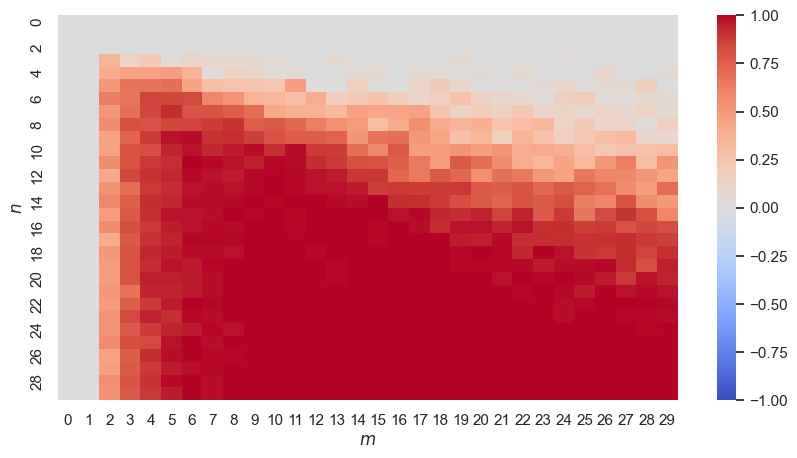

In [8]:
Test.generate_comparison_plot(30, 30)

# Matching

In [9]:
class MatchingGenerator:
    
    @staticmethod
    def generate_matching(rankings, strategy='RMA'):
        """
        
            Parameters:
                rankings (dict): a dictionary {[applicant]: {[job]: [ranking]}}
                strategy ('RMA' | 'RR'): the strategy. RMA for Rank-Maximal Allocation and RR for Round Robin
                
            Returns:
                matching (dict): a dictionary of {[applicant]: [job1, job2, ...]} of selected jobs.
        
        """
        
        # general strategy: convert rankings to a ranking matrix, using inverse indices to convert back
        # given n applicants and m jobs, both strategies return min(n, m) assignments.
        # therefore, if we want to allow applicants to receive multiple jobs, we basically give everyone
        # their top choice first, and then remove the selected items from the pool, and run the process again.
        # we combine all of the results. 
        # in total, each person should receive at minimum floor(m/n) jobs.
        
        applicants = list(rankings.keys())
        applicants_mapping = {applicant: i for i, applicant in enumerate(applicants)}
        applicants_inverse_mapping = {i: applicant for i, applicant in enumerate(applicants)}

        jobs = []
        for applicant in applicants:
            applicant_jobs = rankings[applicant].keys()
            for job in applicant_jobs:
                jobs.append(job)
        jobs = list(set(jobs)) # get unique
        
        total_jobs = len(jobs)
        
        
        matching = {applicant: [] for applicant in applicants}
        while len(jobs) > 0:

            jobs_mapping = {job: j for j, job in enumerate(jobs)}
            jobs_inverse_mapping = {j: job for j, job in enumerate(jobs)}

            n = len(applicants)
            m = len(jobs)

            # default everything to be ranked last
            ranks = m * np.ones((n, m))
            for i in range(n):
                for j in range(m):
                    applicant_name = applicants_inverse_mapping[i]
                    job_name = jobs_inverse_mapping[j]

                    if job_name in rankings[applicant_name]:
                        rank = rankings[applicant_name][job_name]
                        ranks[i, j] = rank

            generate_matching = RankMaximalAllocation.generate_matching if strategy == 'RMA' else RoundRobin.generate_matching
            matched_applicants, matched_jobs = generate_matching(ranks)

            for applicant, job in zip(matched_applicants, matched_jobs):
                applicant_name = applicants_inverse_mapping[applicant]
                job_name = jobs_inverse_mapping[job]
                matching[applicant_name].append(job_name)
                
            for job in matched_jobs:
                job_name = jobs_inverse_mapping[job]
                jobs.remove(job_name)

        
        total_jobs_matched = sum(map(lambda x: len(x), matching.values()))
        assert total_jobs_matched == total_jobs, f'Expected total_jobs_matched to equal {total_jobs} but found {total_jobs_matched}'
        
        return matching

In [10]:
rankings = {
    'alice': {'x':1, 'y':2, 'z':3, 'a':4, 'b':5, 'c': 6, 'd':7},
    'bob':   {'x':3, 'y': 1, 'z':2, 'a':4,'b':5, 'c': 6},
    'jane':   {'x':3, 'y': 2, 'z':1, 'a':4, 'b':5, 'c': 6},
}
MatchingGenerator.generate_matching(rankings)

{'alice': ['x', 'a', 'c'], 'bob': ['y', 'b'], 'jane': ['z', 'd']}

In [11]:
rankings = {
    'alice': {'x':1, 'y':2, 'z':3},
    'bob':   {'x':3, 'y': 1, 'z':2},
    'jane':   {'x':3, 'y': 2, 'z':1},
    'joe':    {'x':1, 'y': 3, 'z':2}
}
MatchingGenerator.generate_matching(rankings)

{'alice': ['x'], 'bob': ['y'], 'jane': ['z'], 'joe': []}

# Parsing

In [12]:
import json

In [13]:
class PreferenceSheetParser:
    @staticmethod
    def generate_ranks(filename):
        xlsx = pd.ExcelFile(filename)
        rankings = {}

        total_quantity = xlsx.parse()['Quantity'].sum()
        minimum_rank = total_quantity - 1

        for sheet_name in xlsx.sheet_names:
            rankings[sheet_name] = {}

            df = pd.read_excel(xlsx, sheet_name)
            
            # Need to handle mistake in sheet where the 'Around the World' set appears twice
            df['Quantity'] = np.where(df['Set Name'] == 'Around the World', 2, df['Quantity'])
            df = df.drop_duplicates('Set Name')
            
            # Normalize rankings so that they begin at 0 instead of 1 
            df['Preference'] -= df['Preference'].min()


            for index, row in df.iterrows():
                rank, qty, name = row['Preference'], row['Quantity'], row['Set Name']
                
                

                rankings[sheet_name][name] = rank

                # all duplicates will be ranked lower than non-duplicates
                # the relative ranking of duplicates will be preserved
                if qty > 1:
                    for duplicate in range(1, qty):
                        rankings[sheet_name][f'{name}_duplicate_{duplicate}'] = minimum_rank*duplicate + rank

            # normalize ranks
            rankings[sheet_name] = {k: v for k, v in zip(rankings[sheet_name].keys(), np.argsort([ v for v in rankings[sheet_name].values()]))}
        
        assert all(map(lambda e: len(e) == total_quantity, rankings.values()))
        return rankings

In [14]:
ranks = PreferenceSheetParser.generate_ranks('2023 Set Draft Form.xlsx')
ranks

{'alex_mocs': {'Flower Bouquet': 0,
  'Wildflower Bouquet': 1,
  'Majestic Tiger': 2,
  'Sunflowers': 3,
  'Sunflowers_duplicate_1': 8,
  'Sunflowers_duplicate_2': 9,
  'Sunflowers_duplicate_3': 10,
  'Sunflowers_duplicate_4': 11,
  'Lloyd’s Legendary Dragon': 12,
  'Dragon of the East': 13,
  'Boba Fett’s Starship™': 14,
  'Hoth™ AT-ST™': 15,
  'Street Racer': 16,
  'Statue of Liberty': 17,
  'Adorable Dogs': 18,
  '007 Aston Martin DB5': 23,
  'Evil Macaque’s Mech': 24,
  'Material Handler': 25,
  'Super Robot': 26,
  'Super Robot_duplicate_1': 27,
  'Super Robot_duplicate_2': 32,
  'Super Robot_duplicate_3': 33,
  'Super Robot_duplicate_4': 38,
  'Cozy House': 39,
  'Death Star™ Trench Run Diorama': 40,
  'Cole’s Dragon Cruiser': 42,
  'King Namor’s Throne Room': 43,
  "Jay's Golden Dragon Motorbike": 44,
  "Jay's Golden Dragon Motorbike_duplicate_1": 49,
  "Jay's Golden Dragon Motorbike_duplicate_2": 50,
  "Jay's Golden Dragon Motorbike_duplicate_3": 60,
  "Jay's Golden Dragon Moto

In [15]:
matching = MatchingGenerator.generate_matching(ranks, strategy='RMA')
matching

{'alex_mocs': ['Creative Monkey Fun_duplicate_2',
  'Pony-Washing Stable_duplicate_1',
  "Shuri's Lab",
  "Jay's Golden Dragon Motorbike_duplicate_2",
  'Cyber Stunt Bike_duplicate_4',
  'Cyber Drone',
  'Cyber Drone_duplicate_4',
  'Wildflower Bouquet',
  'Material Handler',
  'The Ruined Portal',
  'Lloyd’s Legendary Dragon',
  'Off-road Buggy_duplicate_8',
  'The Nether Bastion',
  'Adorable Dogs',
  'Off-road Buggy_duplicate_9',
  'Cozy House',
  'Off-road Buggy_duplicate_4',
  'ATV and Otter Habitat_duplicate_4',
  'Telehandler_duplicate_1',
  'Singapore',
  'Super Robot',
  'Obi-Wan Kenobi’s Jedi Starfighter™',
  'ATV and Otter Habitat_duplicate_6',
  'Creative Monkey Fun_duplicate_3',
  'Off-road Buggy_duplicate_1',
  "Jay's Golden Dragon Motorbike_duplicate_1",
  "Shuri's Lab_duplicate_4",
  'ATV and Otter Habitat_duplicate_7',
  'Telehandler_duplicate_2',
  'Cyber Stunt Bike_duplicate_3',
  'ATV and Otter Habitat_duplicate_1',
  'Off-road Buggy_duplicate_2',
  'Creative Transp

In [16]:
profile = Profile.compute_profile_from_result(ranks, matching)
readable_profile = {i: profile[i] for i in range(len(profile)) if profile[i] != 0}
readable_profile

{0: 1,
 1: 1,
 2: 1,
 3: 1,
 4: 1,
 5: 1,
 6: 1,
 7: 1,
 8: 1,
 9: 1,
 10: 1,
 11: 1,
 12: 1,
 13: 1,
 14: 1,
 15: 1,
 16: 1,
 17: 1,
 18: 1,
 19: 1,
 20: 1,
 21: 1,
 22: 1,
 23: 1,
 24: 1,
 25: 1,
 26: 1,
 27: 1,
 28: 1,
 29: 1,
 30: 1,
 31: 1,
 32: 1,
 33: 1,
 34: 1,
 35: 1,
 36: 1,
 37: 1,
 38: 1,
 39: 1,
 40: 1,
 41: 1,
 42: 1,
 43: 1,
 44: 1,
 45: 1,
 46: 1,
 47: 1,
 48: 1,
 49: 1,
 50: 1,
 51: 1,
 52: 1,
 53: 1,
 54: 1,
 55: 1,
 56: 1,
 57: 1,
 58: 1,
 59: 1,
 60: 1,
 61: 1,
 62: 1,
 63: 1,
 64: 1,
 65: 1,
 66: 1,
 67: 1,
 68: 1,
 69: 1,
 70: 1,
 71: 1,
 72: 1,
 73: 1,
 74: 1,
 75: 1,
 76: 1,
 77: 1,
 78: 1,
 79: 1,
 80: 1,
 81: 1,
 82: 1,
 83: 1,
 84: 1,
 85: 1,
 86: 1,
 87: 1,
 88: 1,
 89: 1,
 90: 1,
 91: 1,
 92: 1,
 93: 1,
 94: 1,
 95: 1,
 96: 1,
 97: 1,
 98: 1,
 99: 1,
 100: 1,
 101: 1,
 102: 1,
 103: 1,
 104: 1,
 105: 1,
 106: 1,
 107: 1,
 108: 1,
 109: 1,
 110: 1,
 111: 1,
 112: 1,
 113: 1,
 114: 1,
 115: 1,
 116: 1,
 117: 1,
 118: 1,
 119: 1,
 120: 1,
 121: 1,
 122: 1,
 12

In [17]:
with open('matching.json', 'w+') as f:
    f.write(json.dumps(matching, indent=2))

In [18]:
with open('ranks.json', 'w+') as f:
    for applicant in ranks:
        for job in ranks[applicant]:
            ranks[applicant][job] = int(ranks[applicant][job])
    
    f.write(json.dumps(ranks, indent=2))